In [ ]:
import pandas as pd
import numpy as np
# Load CSV files
gt = pd.read_csv('bead_data_Sp13 16111 0% Fibrosis.csv')
exp = pd.read_csv('./test_outputs/efficient_test.csv')

# Index by (x,y)
gt_indexed = gt.set_index(['x', 'y'])
exp_indexed = exp.set_index(['x', 'y'])

# Extract coordinates as arrays for KDTree
gt_coords = np.array(gt_indexed.index.tolist())
exp_coords = np.array(exp_indexed.index.tolist())

common_index = gt_indexed.index.intersection(exp_indexed.index)
num_common = len(common_index)

# Compare cy0 and cy1 on common rows
diff_mask = (gt_indexed.loc[common_index, 'cy0'] != exp_indexed.loc[common_index, 'cy0']) | \
            (gt_indexed.loc[common_index, 'cy1'] != exp_indexed.loc[common_index, 'cy1'])
num_diff = diff_mask.sum()
percent_diff = (num_diff / num_common * 100) if num_common > 0 else 0

# Find missing in experiment
missing_in_exp = gt_indexed.index.difference(exp_indexed.index)
num_missing_in_exp = len(missing_in_exp)
percent_missing_in_exp = (num_missing_in_exp / len(gt_indexed) * 100) if len(gt_indexed) > 0 else 0

# Find missing in ground truth
missing_in_gt = exp_indexed.index.difference(gt_indexed.index)
num_missing_in_gt = len(missing_in_gt)
percent_missing_in_gt = (num_missing_in_gt / len(exp_indexed) * 100) if len(exp_indexed) > 0 else 0


# Print results
print(f"Number of (x,y) rows with different cy0 or cy1: {num_diff} ({percent_diff:.2f}%)")
print(f"Number of (x,y) in ground truth missing in experiment: {num_missing_in_exp} ({percent_missing_in_exp:.2f}%)")
print(f"Number of (x,y) in experiment missing in ground truth: {num_missing_in_gt} ({percent_missing_in_gt:.2f}%)")

Number of (x,y) rows with different cy0 or cy1: 11600 (0.58%)
Number of (x,y) in ground truth missing in experiment: 518128 (20.47%)
Number of (x,y) in experiment missing in ground truth: 501831 (19.95%)


In [3]:
# Show rows in ground truth that are missing in experiment
gt_missing_rows = gt_indexed.loc[missing_in_exp]
print("\nRows in ground truth missing in experiment:")

# Show rows in experiment that are missing in ground truth
exp_missing_rows = exp_indexed.loc[missing_in_gt]
print("\nRows in experiment missing in ground truth:")



Rows in ground truth missing in experiment:

Rows in experiment missing in ground truth:


In [4]:
gt_missing_rows.head(20)

cy0  cy1
x  y             
41 210     1    1
   355     2    0
   415     0    0
   941     0    1
   1027    1    3
   1037    0    2
   1474    3    3
   2390    0    2
   2467    3    1
   2485    3    2
   3015    2    3
   3022    0    1
   3261    0    0
   3546    2    2
   4095    3    3
   4117    2    2
   4324    2    0
   4455    2    2
   4491    3    3
   4585    1    1

In [5]:
exp_missing_rows.head(20)

cy0  cy1
x  y             
41 416     0    0
   670     0    0
   942     0    1
   1026    1    3
   1038    0    2
   1594    0    0
   1963    0    0
   2190    3    3
   2466    3    1
   2484    3    2
   2899    2    3
   2971    3    3
   3545    2    2
   3705    2    2
   4325    2    0
   4349    1    3
   4586    1    1
   5626    2    2
   6388    3    1
   6669    2    3

In [70]:
import tifffile as tiff
image = tiff.imread("./test_outputs/changed__SP13 16111 Fibrosis 0% Decoding Cycle 1.ome.tif")

In [71]:
from utils import adjust_contrast
img = image[0][100:1000, 100:1000]  # Adjust slicing as needed
# img = adjust_contrast(img, 25,99)

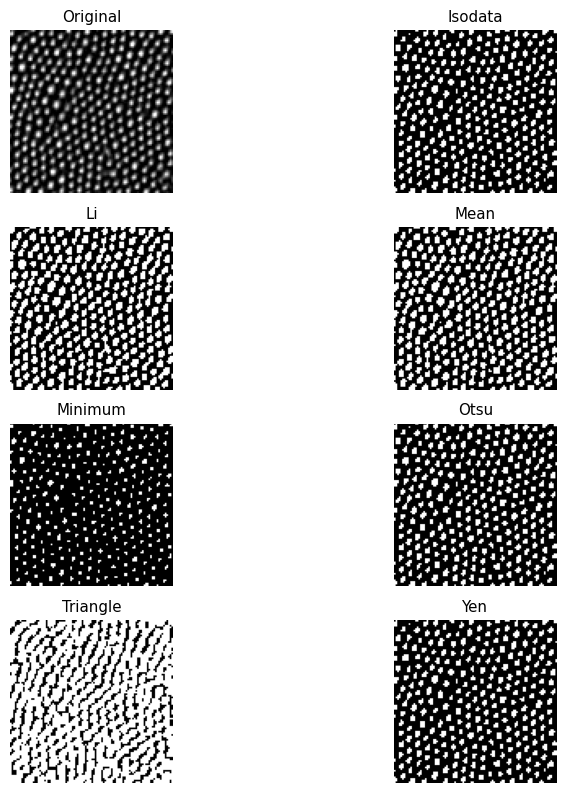

In [49]:
from skimage.filters import try_all_threshold

import matplotlib.pyplot as plt
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

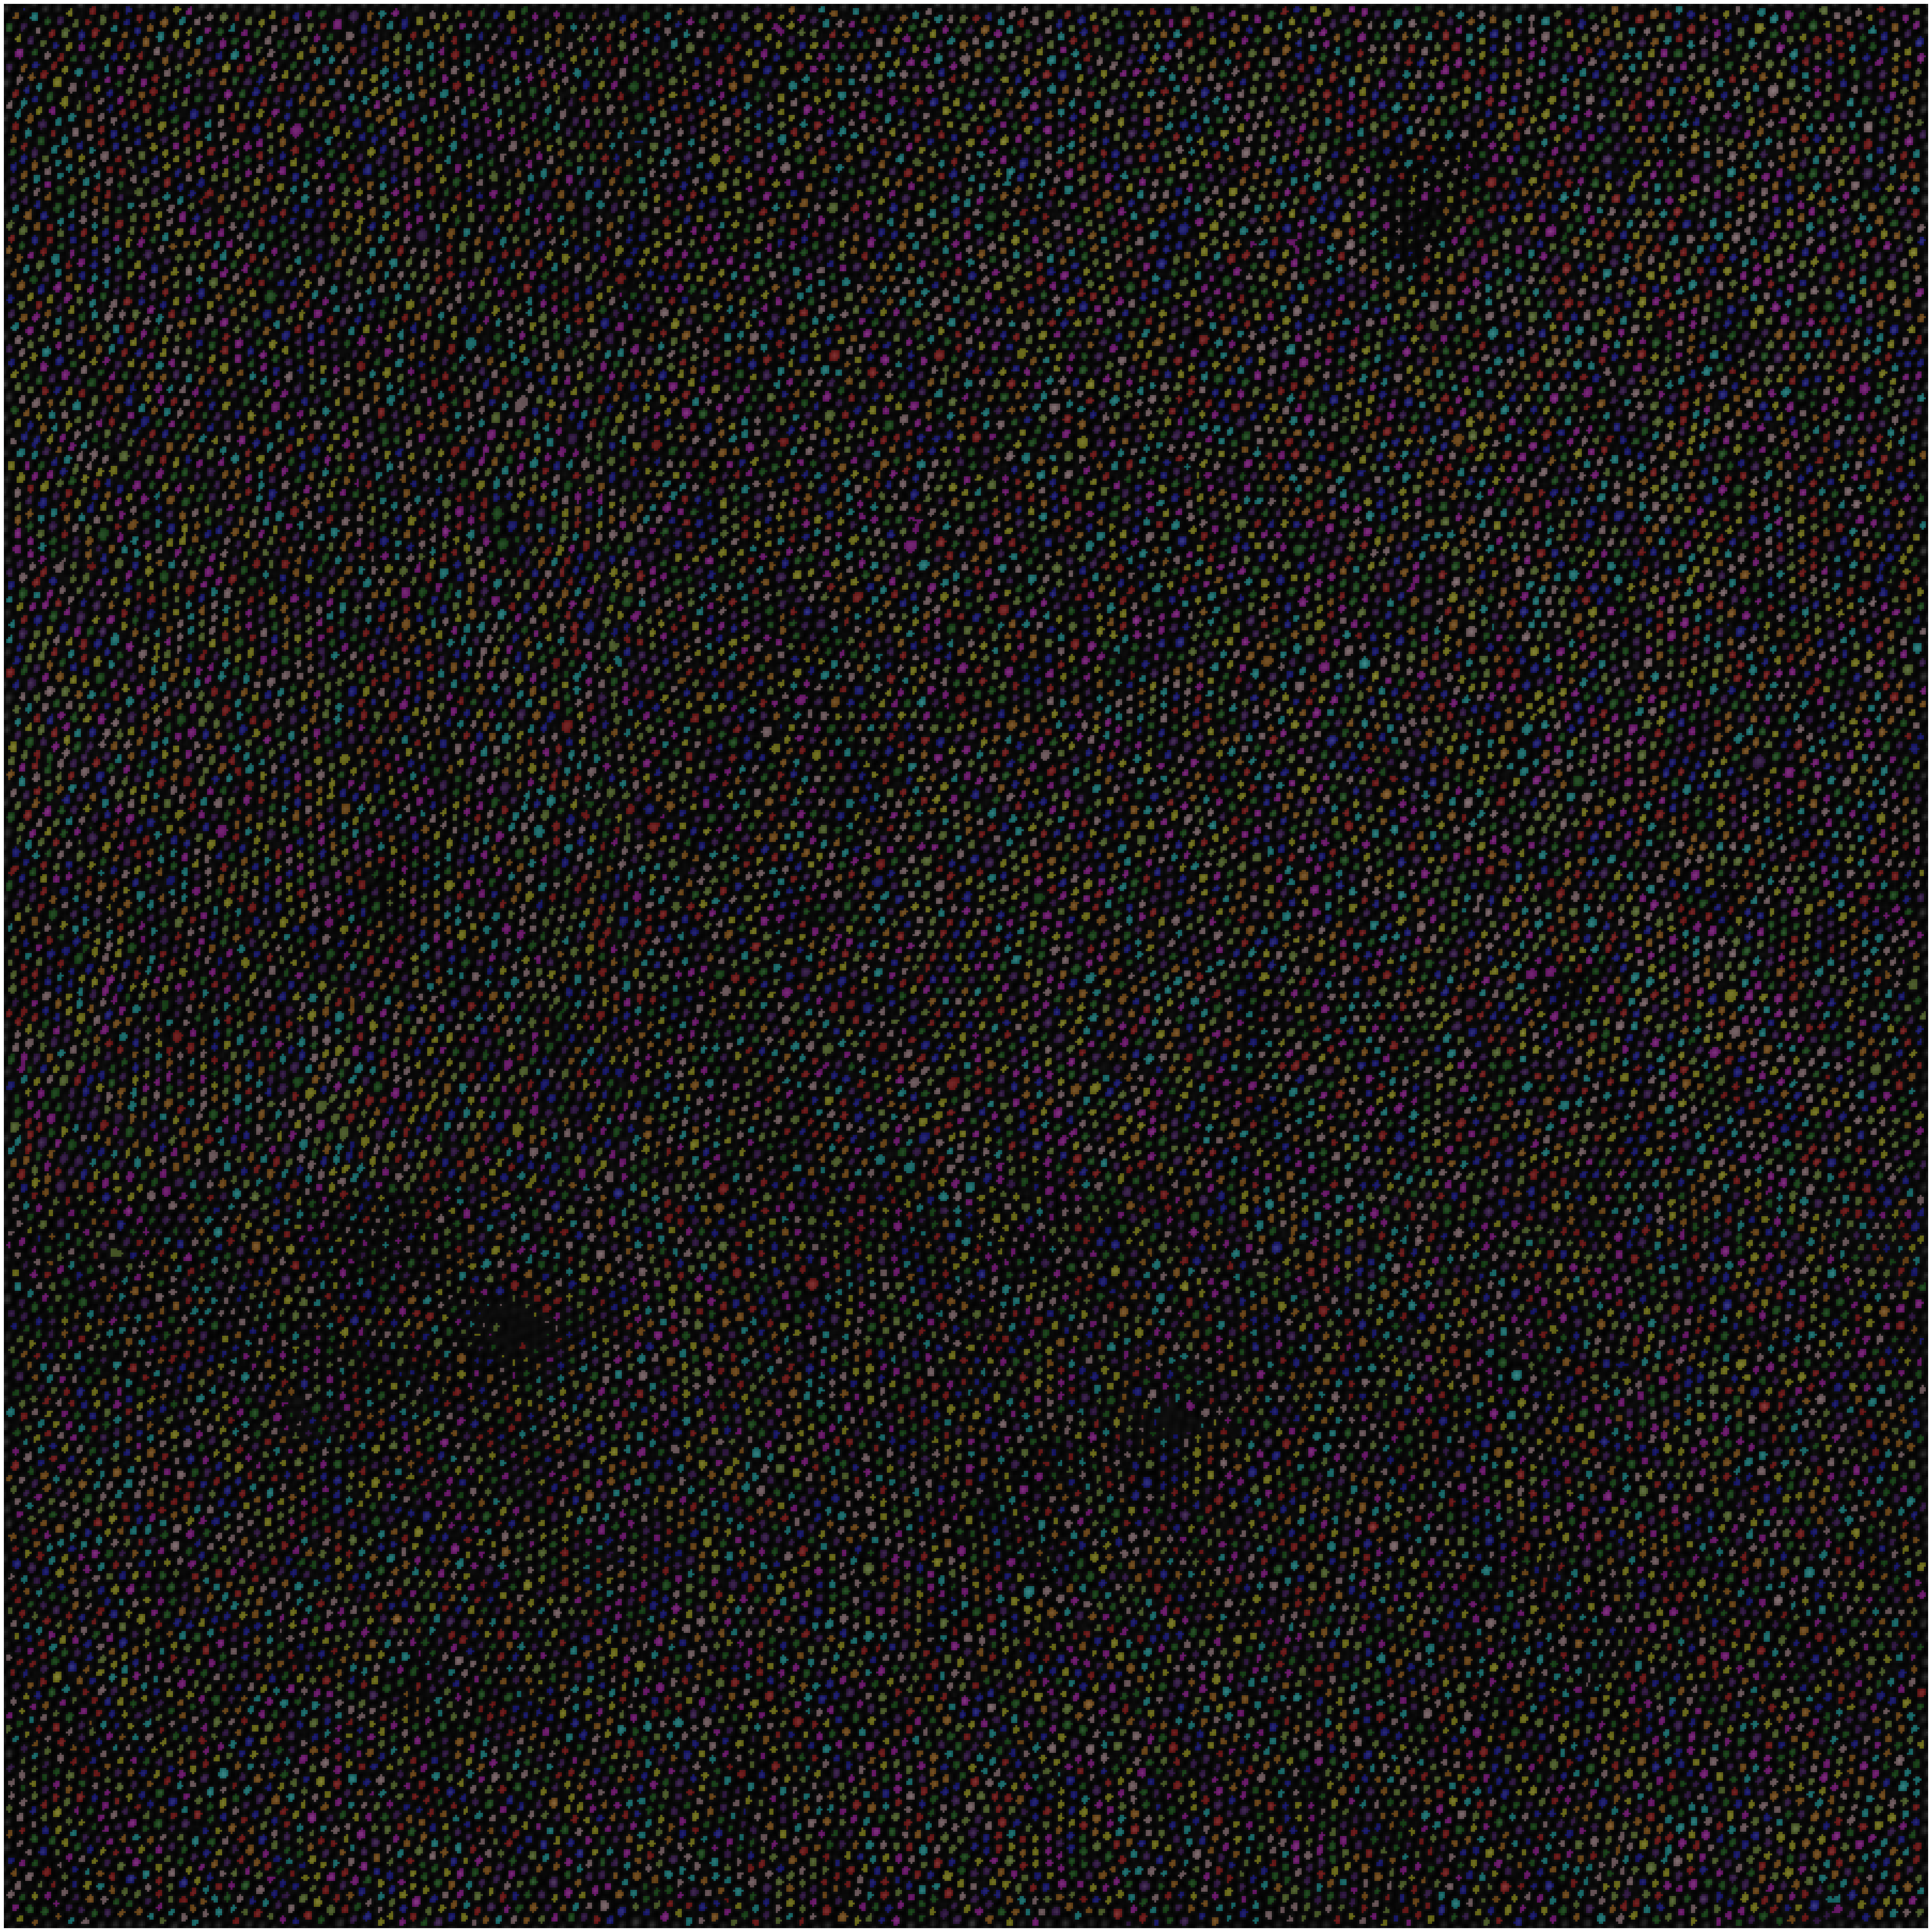

In [73]:
from skimage.segmentation import clear_border
import skimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.morphology import closing, square
mask = skimage.filters.threshold_isodata(img)
bw = closing(img > mask, square(1))

# remove artifacts connected to image border
cleared = clear_border(bw)
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor='red',
            linewidth=2,
        )
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

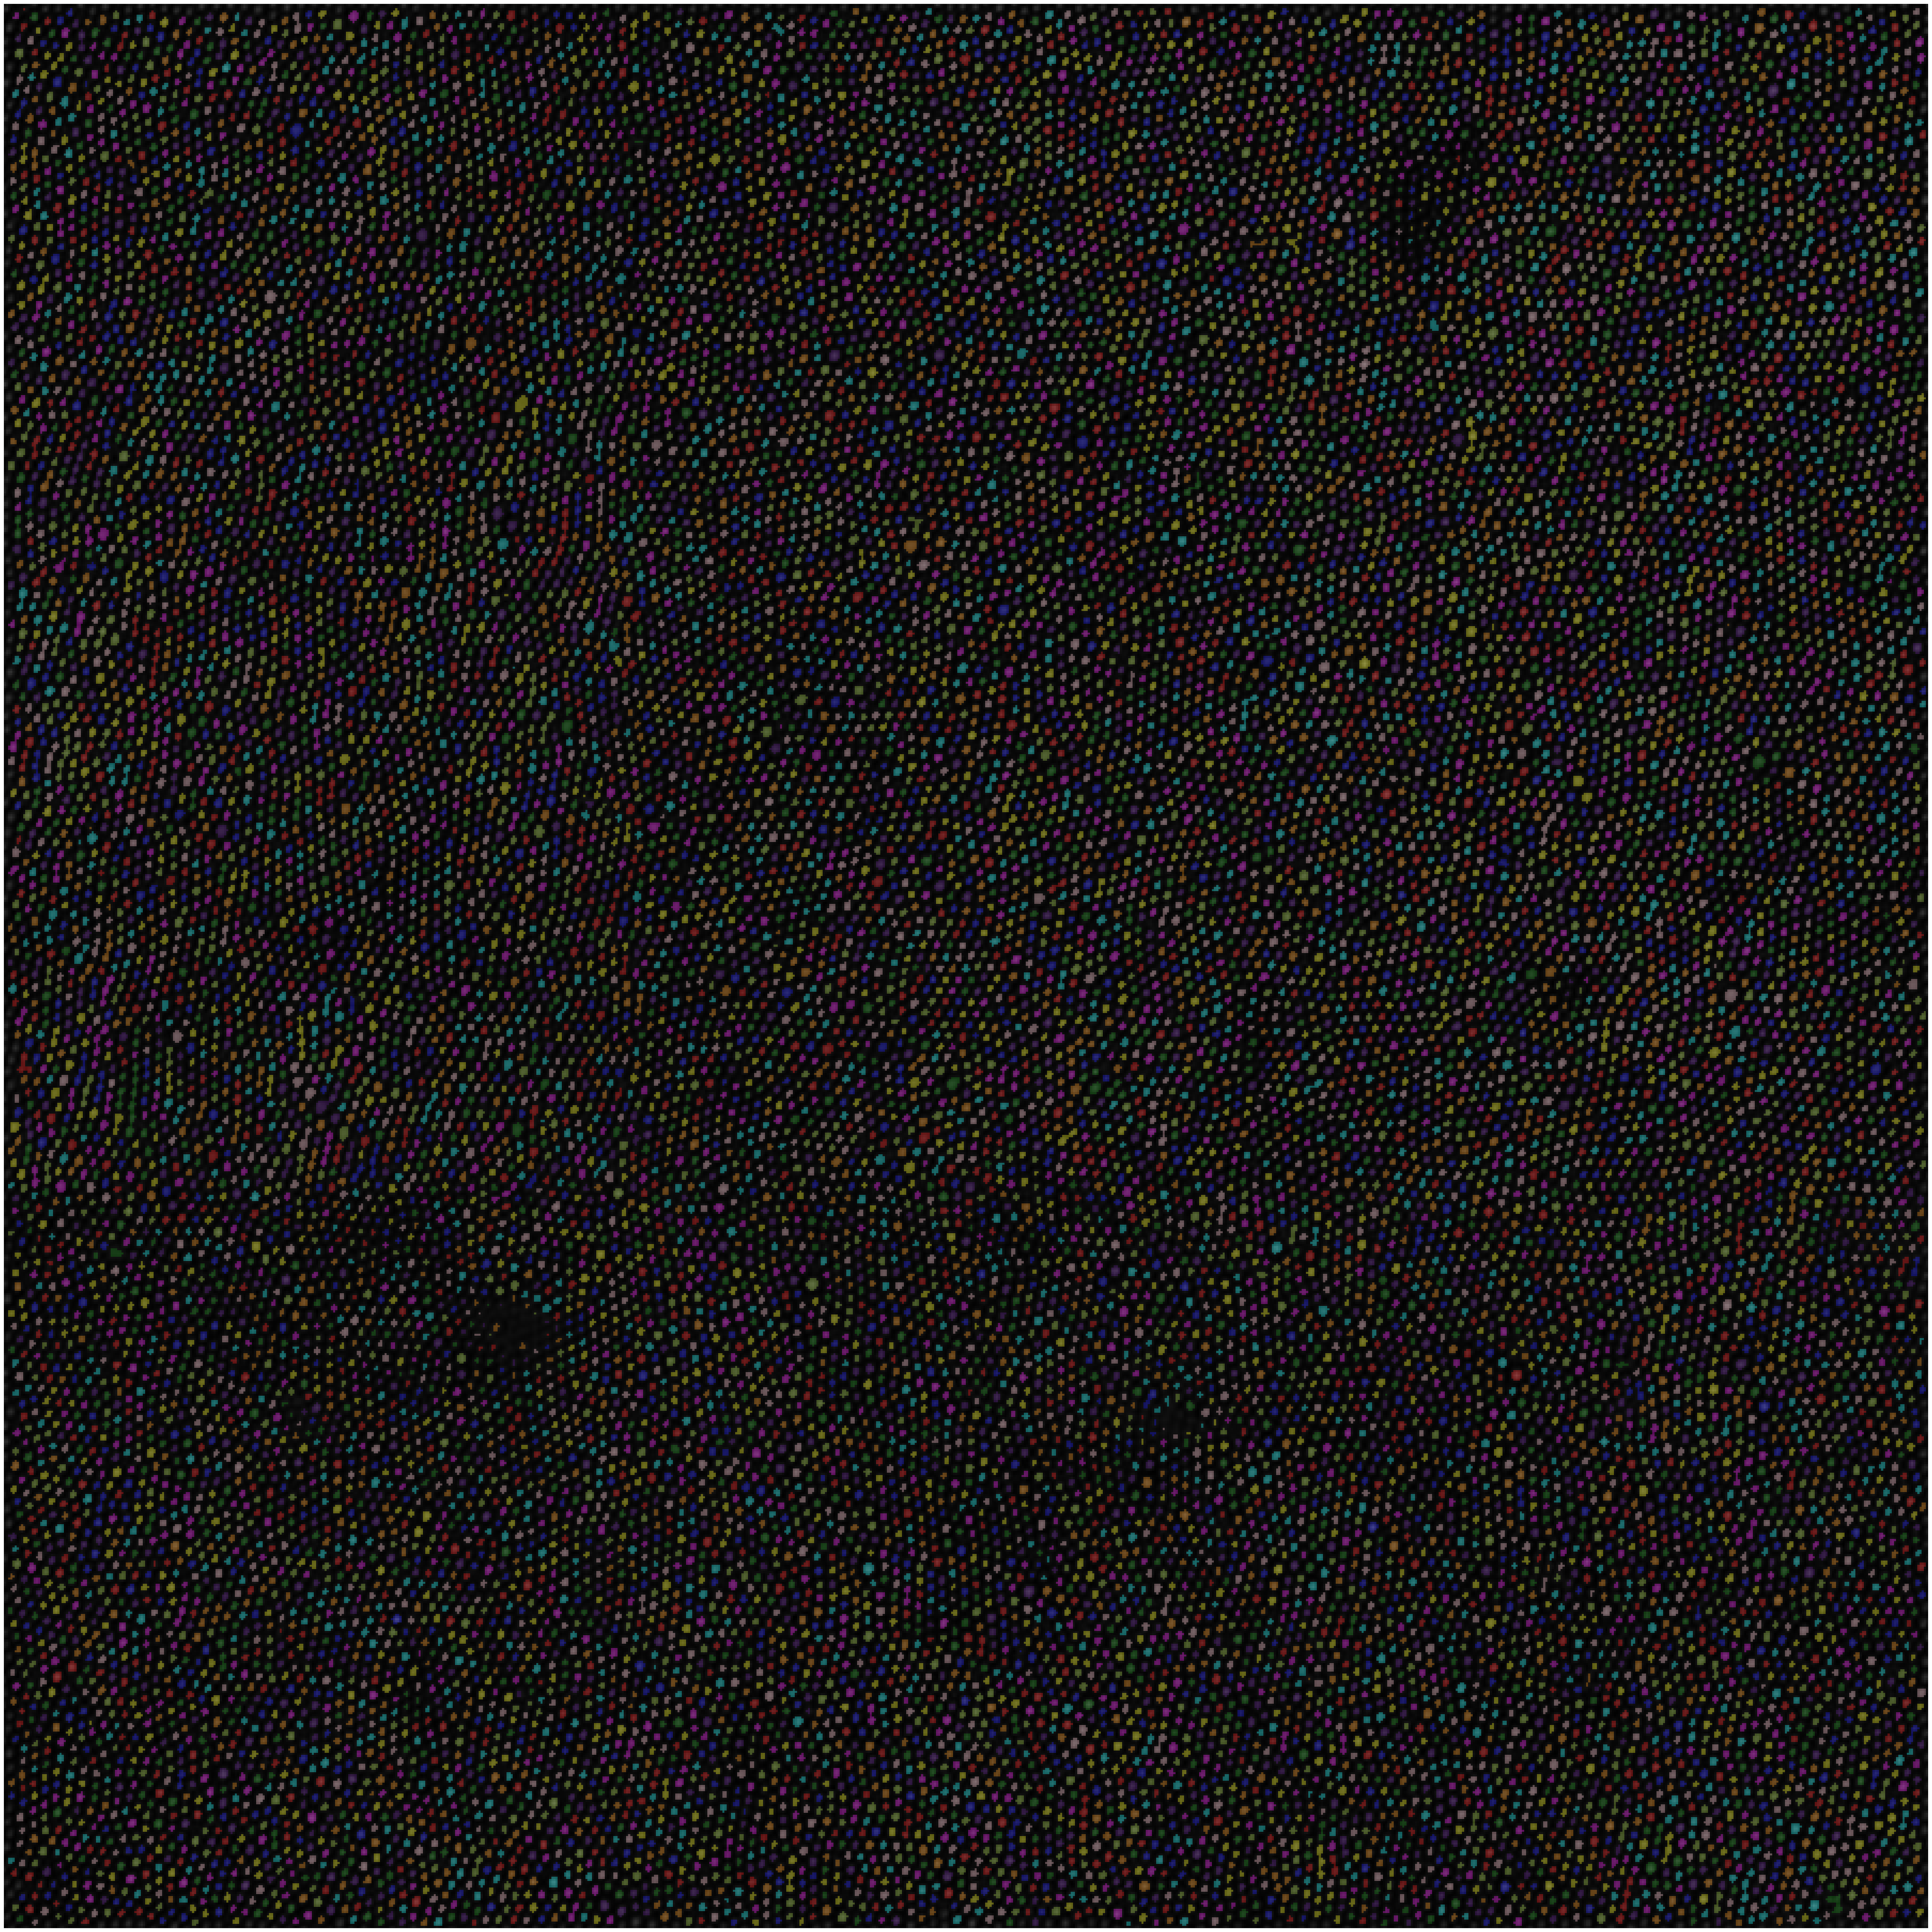

In [74]:
from skimage.segmentation import clear_border
import skimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.morphology import closing, square
mask = skimage.filters.threshold_otsu(img)
bw = closing(img > mask, square(2))

# remove artifacts connected to image border
cleared = clear_border(bw)
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor='red',
            linewidth=2,
        )
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [86]:
import cv2
import numpy as np
import diplib as dip
def thresholding(image):
    def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
        """Return a sharpened version of the image, using an unsharp mask."""
        blurred = cv2.GaussianBlur(image, kernel_size, sigma)
        sharpened = float(amount + 1) * image - float(amount) * blurred
        sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
        sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
        sharpened = sharpened.round().astype(np.uint8)
        if threshold > 0:
            low_contrast_mask = np.absolute(image - blurred) < threshold
            np.copyto(sharpened, image, where=low_contrast_mask)
        return sharpened

    def adjust_contrast(img, min=2, max=98):
        img = np.nan_to_num(img, nan=0.0, posinf=255, neginf=0)
        minval = np.percentile(img, min)
        maxval = np.percentile(img, max)
        epsilon = 1e-8
        img = np.clip(img, minval, maxval)
        img = ((img - minval) / (maxval - minval + epsilon)) * 255
        return img.astype(np.uint8)

    image_modified = np.invert(adjust_contrast(unsharp_mask(image)))

    # this is just the standard thresholding function from opencv
    # more can be found https://docs.opencv2.org/4.x/d7/dd0/tutorial_js_thresholding.html
    image_modified = cv2.adaptiveThreshold(
        unsharp_mask(image_modified),
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        11,
        50,
    )

    # this removes large connected components
    # image_modified = image_modified + np.invert(
    #     np.array(dip.AreaClosing(image_modified, filterSize=20, connectivity=2))
    # )

    return image_modified
def scale(arr):
    return ((arr - arr.min()) * (1 / (arr.max() - arr.min()) * 255)).astype("uint8")


def preprocess_brightfield(brightfield, max_size):
    return scale(brightfield)[:max_size, :max_size]

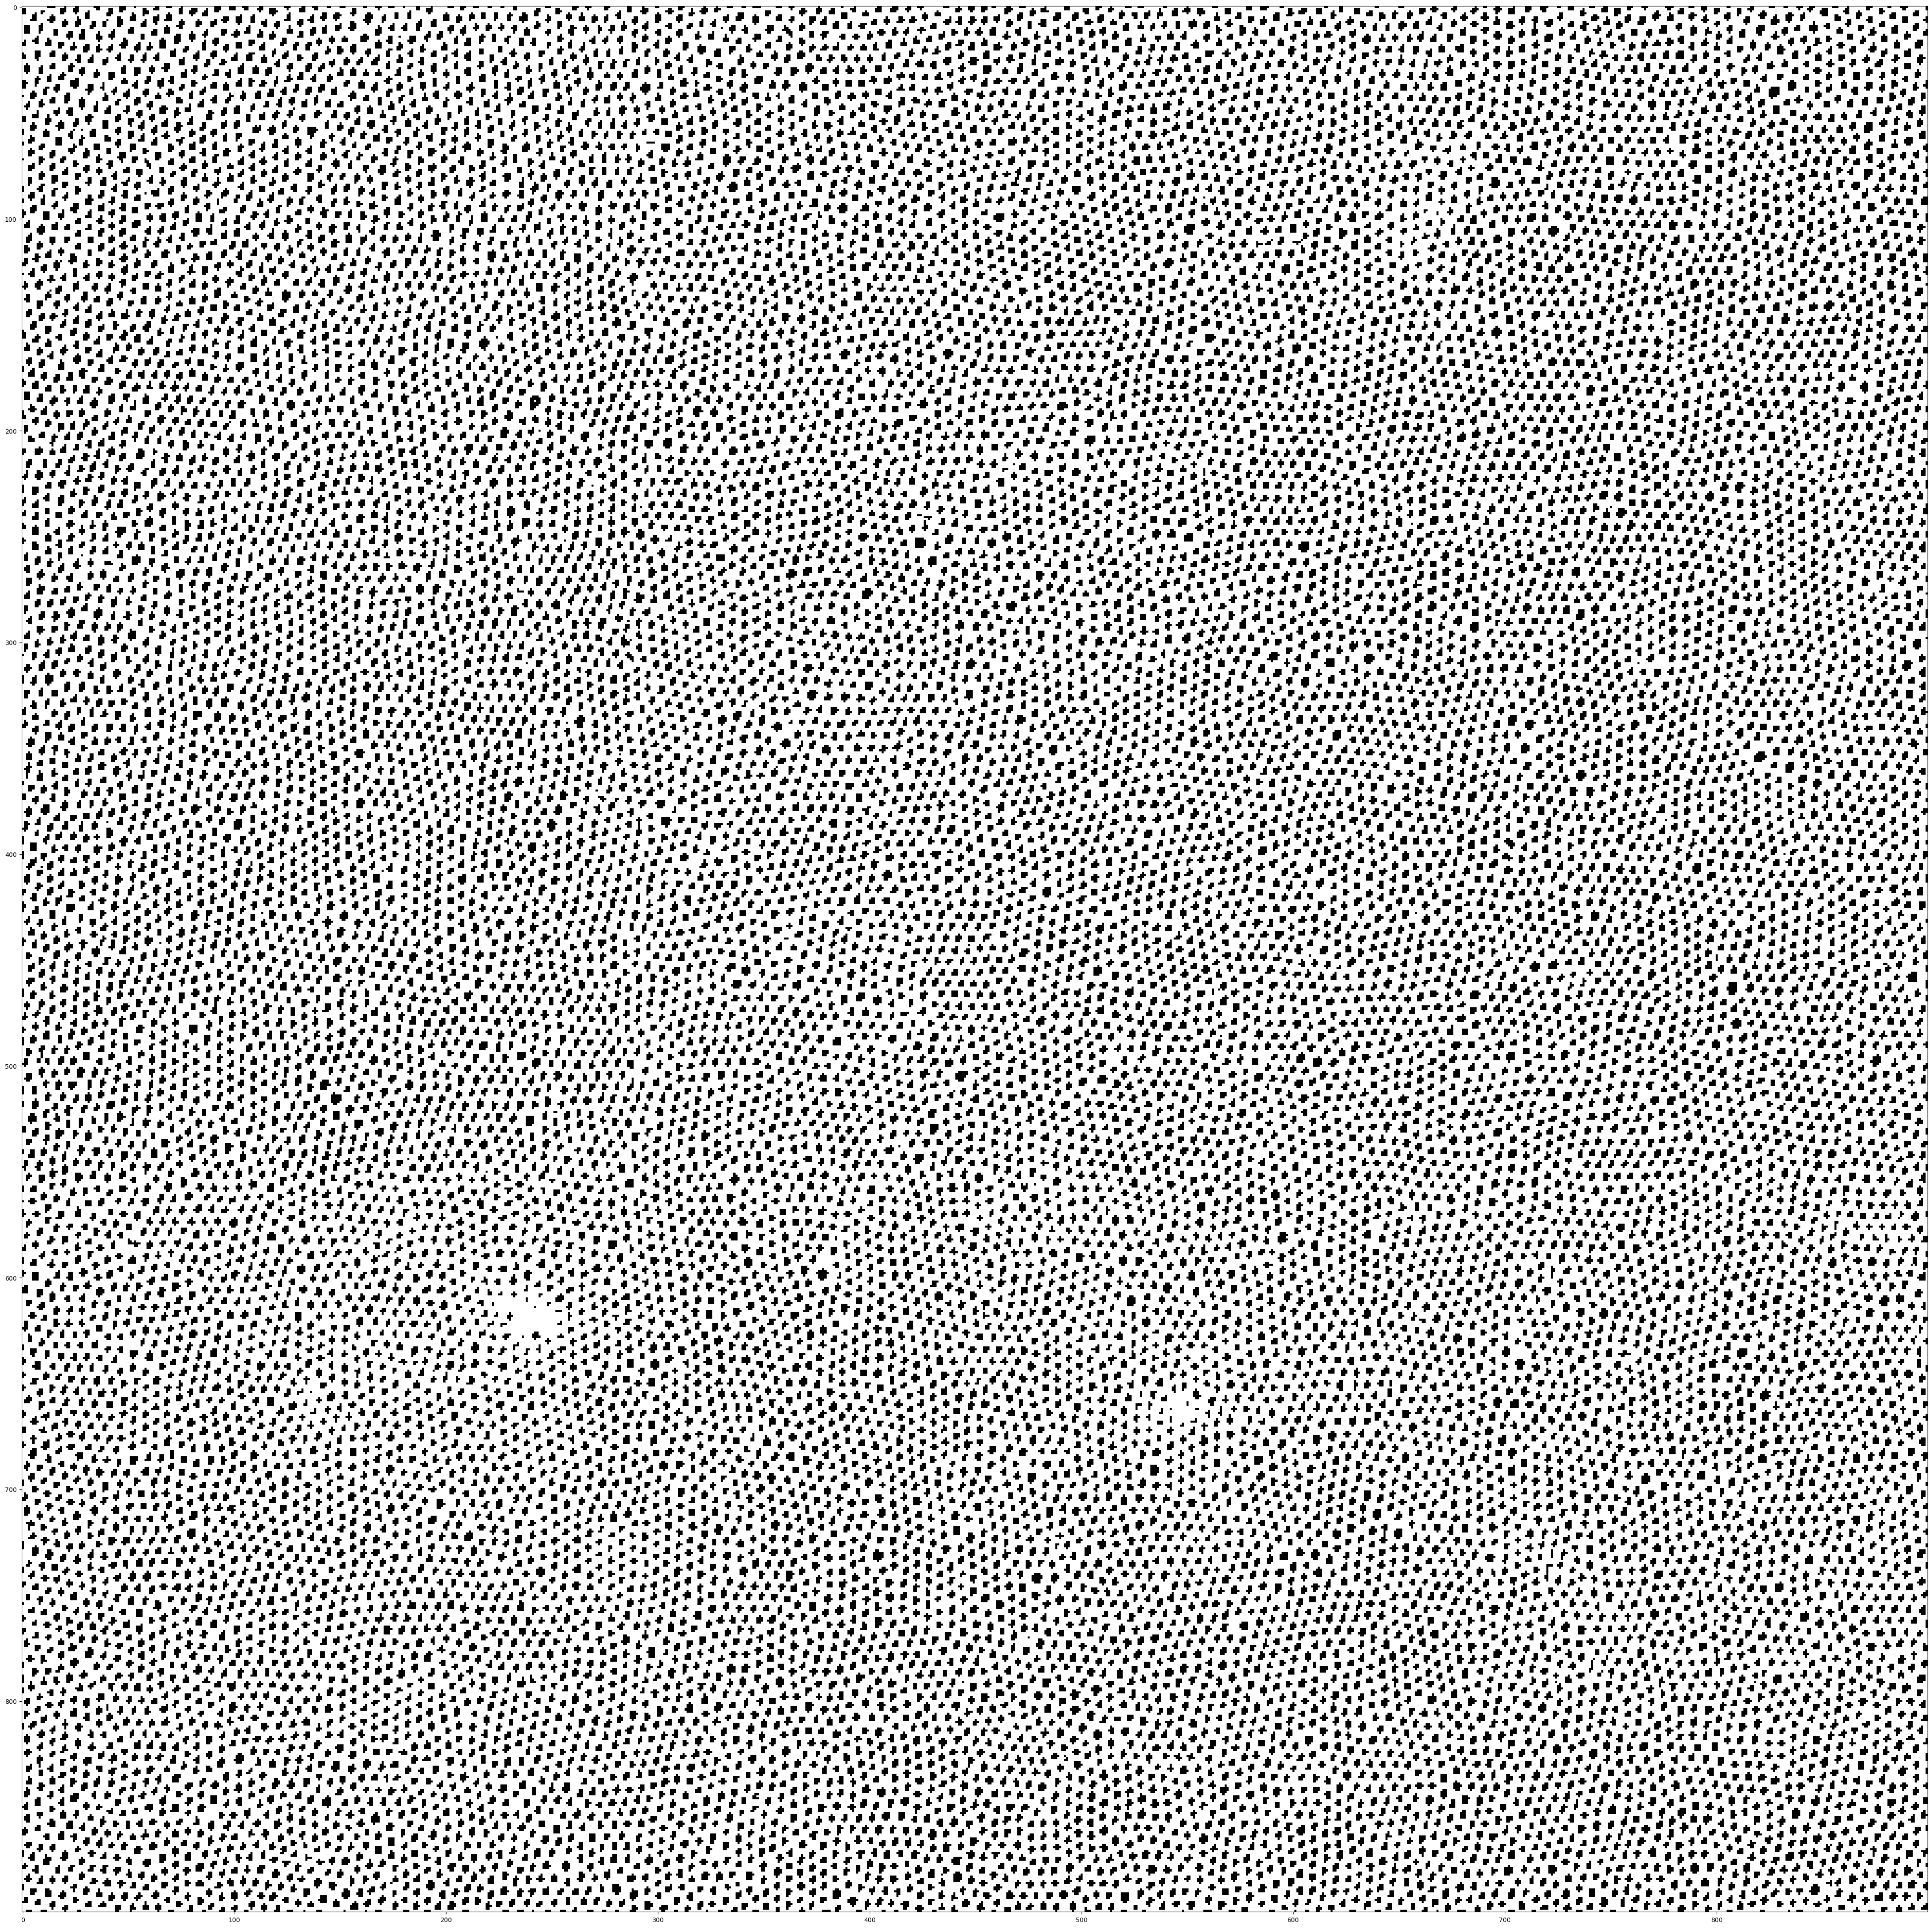

In [87]:
og_img = image[0,100:1000,100:1000]
og_img = scale(og_img)
plt.figure(figsize=(50, 50))
plt.imshow(thresholding(og_img), cmap='gray')

In [72]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, restoration, util


def plot_result(image, background):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(background, cmap='gray')
    ax[1].set_title('Background')
    ax[1].axis('off')

    ax[2].imshow(image - background, cmap='gray')
    ax[2].set_title('Result')
    ax[2].axis('off')

    fig.tight_layout()



background = restoration.rolling_ball(img)
img = img-background
# plot_result(img, background)
# plt.show()

In [10]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology

# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(img)
mask = img > threshold
mask = morphology.remove_small_objects(mask, 2)
mask = morphology.remove_small_holes(mask, 2)
labels = measure.label(mask)

fig = px.imshow(img, binary_string=True)
fig.update_traces(hoverinfo='skip')  # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            name=label_i,
            mode='lines',
            fill='toself',
            showlegend=False,
            hovertemplate=hoverinfo,
            hoveron='points+fills',
        )
    )

plotly.io.show(fig)

KeyboardInterrupt: 